In [1]:
#orignial author Austin Lawson
#modifications ic
#Package importation

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
%matplotlib inline
from scipy.spatial.distance import pdist,cdist
from scipy.stats import gaussian_kde
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from collections import defaultdict
from shapely.geometry import Polygon,Point
from operator import itemgetter
import gudhi
import scipy
from scipy import optimize
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
import patsy
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
    
import pandas as pd

import matplotlib.cm as cm #for vornoi plots

In [2]:
#sourced from PR_generation.ipynb
pd1_low = np.load("PDoriginal/PDlownoise.npy",allow_pickle=True)
pd1_med = np.load("PDoriginal/PDmednoise.npy",allow_pickle=True)
pd1_hig = np.load("PDoriginal/PDhignoise.npy",allow_pickle=True)

In [3]:
def make_boundary(win):
    """
    Makes a 4 corner boundary from a list of parameters
    @param win: is a quadruple of the form (xmin,xmax,ymin,ymax)
    @output boundary: a 4x2 array of rectangle vertices in cyclic order
    """
    b1=win[0]
    b2=win[1]
    b3=win[2]
    b4=win[3]
    boundary = np.array([[b1,b3],[b1,b4],[b2,b4],[b2,b3]])
    return boundary

def voronoi_polygons(voronoi, diameter):
    """
    Generate shapely.geometry.Polygon objects corresponding to the
    regions of a scipy.spatial.Voronoi object, in the order of the
    input voronoi. The polygons for the infinite regions are large
    enough that all voronoi within a distance 'diameter' of a Voronoi
    vertex are contained in one of the infinite polygons.
    @param voronoi: A Voronoi object from scipy.spatial
    @param diameter: A scalar
    """
    centroid = voronoi.points.mean(axis=0)

    # Mapping from (input point index, Voronoi point index) to list of
    # unit vectors in the directions of the infinite ridges starting
    # at the Voronoi point and neighbouring the input point.
    ridge_direction = defaultdict(list)
    for (p, q), rv in zip(voronoi.ridge_points, voronoi.ridge_vertices):
        u, v = sorted(rv)
        if u == -1:
            # Infinite ridge starting at ridge point with index v,
            # equidistant from input P with indexes p and q.
            t = voronoi.points[q] - voronoi.points[p] # tangent
            n = np.array([-t[1], t[0]]) / np.linalg.norm(t) # normal
            midpoint = voronoi.points[[p, q]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - centroid, n)) * n
            ridge_direction[p, v].append(direction)
            ridge_direction[q, v].append(direction)

    for i, r in enumerate(voronoi.point_region):
        region = voronoi.regions[r]
        if -1 not in region:
            # Finite region.
            yield Polygon(voronoi.vertices[region])
            continue
        # Infinite region.
        inf = region.index(-1)              # Index of vertex at infinity.
        j = region[(inf - 1) % len(region)] # Index of previous vertex.
        k = region[(inf + 1) % len(region)] # Index of next vertex.
        if j == k:
            # Region has one Voronoi vertex with two ridges.
            dir_j, dir_k = ridge_direction[i, j]
        else:
            # Region has two Voronoi vertices, each with one ridge.
            dir_j, = ridge_direction[i, j]
            dir_k, = ridge_direction[i, k]

        # Length of ridges needed for the extra edge to lie at least
        # 'diameter' away from all Voronoi vertices.
        length = 2 * diameter / np.linalg.norm(dir_j + dir_k)

        # Polygon consists of finite part plus an extra edge.
        finite_part = voronoi.vertices[region[inf + 1:] + region[:inf]]
        extra_edge = [voronoi.vertices[j] + dir_j * length,
                      voronoi.vertices[k] + dir_k * length]
        yield Polygon(np.concatenate((finite_part, extra_edge)))


def get_unnormalized_areas(P,boundary):
    """
    This produces a dictionary of areas normalized by the max for each Voronoi cell generated by P of @param P, 
    restricted to @param boundary
    
    @param P: an nx2 list of P in the plane
    @param boundary: 4x2 list of rectangle vertices in cylcic order (best to just use the make_boundary function to create boundary from a 1-d vector)
    @output polys: a dictionary of polygons that are the Voronoi cells where polys[i] is the voronoi cell polygon generated by P[i]
    @output areas: a dictionary of areas where areas[i] is the area of the cell generated by P[i]
    """
    V = Voronoi(P,qhull_options="Qc",) #Computes a Voronoi diagram on P P
    x, y = boundary.T #get boundary limits
    diameter = np.linalg.norm(boundary.ptp(axis=0)) #computes the diameter of the rectangle
    boundary_polygon = Polygon(boundary) #creates the boundary rectangle
    #initialize the vornoi polygons and areas
    polys = {} 
    areas = {}
    k=0
    for p in voronoi_polygons(V, diameter): #Get the areas of the voronoi polygons
        x, y = zip(*p.intersection(boundary_polygon).exterior.coords)
        poly = np.stack([x,y],axis=1)
        polys[k] = poly
        areas[k] = ConvexHull(poly).volume
        k+=1
    return polys,areas
def get_areas(P,boundary):
    """
    This produces a dictionary of areas normalized by the max for each Voronoi cell generated by P of @param P, 
    restricted to @param boundary
    @param P: an nx2 list of P in the plane
    @param boundary: 4x2 list of rectangle vertices in cylcic order (best to just use the make_boundary function to create boundary from a 1-d vector)
    @output polys: a dictionary of polygons that are the Voronoi cells where polys[i] is the voronoi cell polygon generated by P[i]
    @output aas: a dictionary of areas (normalize by maximum) where areas[i] is the normalized area of the cell generated by P[i]
    """
    V = Voronoi(P,qhull_options="Qc",) #Computes a Voronoi diagram on P P
    x, y = boundary.T #get boundary limits
    diameter = np.linalg.norm(boundary.ptp(axis=0)) #computes the diameter of the rectangle
    boundary_polygon = Polygon(boundary) #creates the boundary rectangle
    #initialize the vornoi polygons and areas
    polys = {} 
    areas = {}
    k=0
    for p in voronoi_polygons(V, diameter): #Get the areas of the voronoi polygons
        x, y = zip(*p.intersection(boundary_polygon).exterior.coords)
        poly = np.stack([x,y],axis=1)
        polys[k] = poly
        areas[k] = ConvexHull(poly).volume
        k+=1
    aas = {k: v/max(areas.values()) for k,v in areas.items()} #normalize by max
    return polys,aas

def A(x,P,areas):
    """
    for each point pt in the collection of P @param x, compute the normalized area of the voronoi cell where pt lies.
    The Voronoi cells are generated by @param P and restricted to @param boundary.
    @param x: an nx2 array of P in the plane for which to compute the areas
    @param P: an nx2 array of P in the plane
    @param areas: a nx1 array of area values associated to P in P
    @output: the area of the Voronoi cell in which x lies
    """
    #polys,areas = get_areas(P,boundary)
    return itemgetter(*list(np.argmin(cdist(P,x),axis=0)))(areas)

def h(x1,x2,kappa,sigma):
    """
    Computes the interaction value between two P given an interaction value and distance threshold number
    @param x1,x2: P between which to compute interaction (both should be 1x2)
    @param kappa: the interaction value, single value in (0,1)
    @param sigma: the distance threshold number, single value
    @output: the interaction value between x1 and x2
    """
    dist = np.sqrt(np.sum(np.square(x1-x2))) #Compute the distance between x1,x2
    h1=(sigma/dist)**(2/kappa)
    hh=np.exp(-1*h1)
    return hh

def h_prod(D,kappa,sigma):
    """
    Computes the product of the interactions of points in a set D
    @param D: an nx2 set of points in the plane
    @param kappa: the interaction value, single value in (0,1)
    @param sigma: the distance threshold number (a kx1 array)
    @output H: the product of the interactions of points in D
    """
    D = D.reshape(-1,2) #forces D to be 2-dimensional (this is useful in the case where D has just one point
    #compute interaction product
    H=0 #initialize H
    for i in range(D.shape[0]-1):
        for j in range(i+1,D.shape[0]): #loop over the indices of the upper trianglular matrix 
            x1 = D[i,:]
            x2 = D[j,:]
            H += np.log(h(x1,x2,kappa,sigma)) #compute the interaction then take the log
    H = np.exp(H) #exponentiate
    return H

In [4]:
#coding for rj-mcmc steps

def RPDG_add(D_current, P, areas,kappa,sigma,boundary,lambdaW):
    """
    Proposes, computes acceptance for adding a point, and returns result (accepted value or original)
    @param D_current: An nx2 array of P
    @param P: the Voronoi cell generating P (an mx2 array)
    @param areas: the area values associated to P in P (an mx1 array)
    @param kappa: The an irregular parameter valued between [0,1] (singular value)
    @param sigma: The distance jump valued non-negative (singular value)
    @param boundary: 4x2 list of rectangle vertices in cylcic order (best to just use the make_boundary function to create boundary from a 1-d vector)
    @param lambdaW: a scalar (this is the average number of P in the boundary)
    @output: If add is accepted, outputs D_current plus proposed point, otherwise outputs D_current
    """
    
    b1,b2,b3,b4 = boundary[0,0],boundary[2,0],boundary[0,1],boundary[1,1] #Get the boundary values in order xmin,xmax,ymin,ymax
    D_current = D_current.reshape(-1,2) #Force D to be 2-D
    #The following samples a uniformly random point within the boundary
    d_prop1 = np.random.uniform(b1,b2)
    d_prop2 = np.random.uniform(b3,b4)
    d_prop = np.array((d_prop1,d_prop2)).reshape(-1,2)
    #Compute the interaction values between the proposed point and the existing P   
    h_prop = 0
    for i in range(D_current.shape[0]):
        if np.sqrt(np.sum(np.square(d_prop-D_current[i,:])))<10^-7:
            return D_current
        h_prop = h_prop + np.log(h(D_current[i,:],d_prop,kappa,sigma))
    #compute the acceptance probability (in accordance with the lemma in the RPDG paper) and evaluate
    a = lambdaW*(np.exp(h_prop)*A(d_prop,P,areas))/(D_current.shape[0]+1)
    u = np.random.uniform()
    if u<a:
        return np.append(D_current,d_prop,axis=0)
    return D_current

def RPDG_rem(D_current, P, areas, kappa, sigma ,boundary ,lambdaW):
    """
    Proposes and computes acceptance for removing a point, and returns either D_current or the proposed diagram
    @param D_current: An nx2 array of P
    @param P: the Voronoi cell generating P (an mx2 array)
    @param areas: the area values associated to P in P (an mx1 array)
    @param kappa: The an irregular parameter valued between [0,1] (singular value)
    @param sigma: The distance jump value valued non-negative (singular value)
    @param boundary: 4x2 list of rectangle vertices in cylcic order (best to just use the make_boundary function to create boundary from a 1-d vector)
    @param lambdaW: a scalar (this is the average number of P in the boundary)
    @output: If removal is accepted, outputs D_prop, otherwise outputs D_current 
    """
    D_current = D_current.reshape(-1,2) #This reshapes D_current to the correct shape (necessary if D_current contains only one point in the plane)
    k = np.random.choice(np.arange(D_current.shape[0])) #Randomly select a point of D_current to drop
    d_prop = D_current[k,:] #assign the selected point to d_prop
    D_prop = np.delete(D_current,k,axis=0) #assign the set D_prop to D_current with the selected point deleted
    D_prop = D_prop.reshape(-1,2) #reshape
    h_prop = 0 #initilize the interaction
    #Compute the interactions of d_prop with D_prop
    for i in range(D_prop.shape[0]):
        h_prop = h_prop + np.log(h(D_prop[i,:],d_prop.reshape(-1,2),kappa,sigma))
    a = (D_current.shape[0]-1)/(np.exp(h_prop)*A(d_prop.reshape(-1,2),P,areas)*lambdaW) #compute the acceptance probability
    #decide whether to accept or reject proposal
    u = np.random.uniform()
    if u<a:
        return D_prop
    return D_current

def Q_diagram_sample(mg,sg,wt):
    """
    Sample from a Gaussian mixture where each component has an isotropic covariance matrix
    @param mg: the means of the components (nx2)
    @param sg: the variances of the components (nx1)
    @param wt: the weights of the components (nx1)
    @output d_prop: the value sampled from the mixture
    """
    g = np.random.choice(np.arange(wt.shape[0]),p = wt) #select one of the three components with propbability p
    d_prop = stats.multivariate_normal.rvs(mean = mg[g,:],cov = sg[g]*np.eye(2)) #draw from multivariate normal
    return d_prop

def Q_diagram_eval(x,mg,sg,wt):
    """
    evaluate a Gaussian mixture where each component has an isotropic covariance matrix at a given point or P
    @param x: the point or P at which to evaluate the pdf (mx2)
    @param mg: the means of the components (nx2)
    @param sg: the variances of the components (nx1)
    @param wt: the weights of the components (nx1) 
    @output out: the value of the pdf at x
    """
    x = x.reshape(-1,2) #reshape x to an mx2 array
    out = 0 #initialize the return
    for i in range(wt.shape[0]): #loop over the three components and add their corresponding pdf values at x
        out = out + wt[i]*stats.multivariate_normal.pdf(x,mean = mg[i,:],cov = sg[i])
    return out

def RPDG_mov(D_current, P, areas, kappa, sigma, boundary,mg,sg,wt):
    """
    Proposes, computes acceptance for moving a point, and returns result (accepted value or original). Uses both Q_diagram_sample and Q_diagram_eval
    hence contains their inputs mg,sg,wt
    @param D_current: An nx2 array of P
    @param P: the Voronoi cell generating P (an mx2 array)
    @param areas: the area values associated to P in P (an mx1 array)
    @param theta: The interaction vector (a kx1 array)
    @param r: The distance jump vector (a kx1 array)
    @param boundary: 4x2 list of rectangle vertices in cylcic order (best to just use the make_boundary function to create boundary from a 1-d vector)
    @param mg: the means of the components (nx2)
    @param sg: the variances of the components (nx1)
    @param wt: the weights of the components (nx1)
    @output: if move is accepted, returns D_prop, otherwise returns D_current
    """
    d_prop = Q_diagram_sample(mg,sg,wt) #propose a point
    if not Polygon(boundary).contains(Point(d_prop)): #if the proposed point is not in the boundary, automatic reject
        return D_current
    
    k = np.random.choice(np.arange(D_current.shape[0]))#select a random point in D_current
    
    for i in range(D_current.shape[0]):
        if np.sqrt(np.sum(np.square(d_prop-D_current[i,:])))<10^-7:
            return D_current   
    d_current = D_current[k,:]
    #D_prop is D_current, but replaces the kth point of D with D_prop
    D_prop = D_current.copy()
    D_prop[k,:] = d_prop
    #evaluate both individual P at D
    q_old = Q_diagram_eval(d_current,mg,sg,wt)
    q_prop = Q_diagram_eval(d_prop,mg,sg,wt)
    
    #Evaluate the areas of the Voronoi cells containing d_current and d_prop
    A_old = A(d_current.reshape(-1,2),P,areas)
    A_prop = A(d_prop.reshape(-1,2),P,areas)
    
    #Evaluate the product of the interactions in the two diagrams
    H_old = h_prod(D_current,kappa, sigma)
    H_prop = h_prod(D_prop,kappa, sigma)
    
    
    #Divide the values
    qrat = np.exp(np.log(q_old)-np.log(q_prop))
    Arat = A_prop/A_old
    Hrat = np.exp(np.log(H_prop)-np.log(H_old))
    a = qrat*Arat*Hrat

    u = np.random.uniform()
    if u<a:
         return D_prop
    return D_current

def RPDG_multi(steps,burnin,D_current, P, kappa, sigma,boundary,lambdaW,mg,sg,wt,probs=[1/3,1/3,1/3],areas = None):
    """
    This function samples random diagrams given parameters
    @param steps: the number of diagrams sampled
    @param burnin: the number of diagrams to be cut from the beginning
    @param D_current: The initial point set from which to begin the iteration
    @param P: the Voronoi cell generating P (an mx2 array)
    @param theta: the interaction vector
    @param r: the distance jump vector
    @param boundary: 4x2 list of rectangle vertices in cylcic order (best to just use the make_boundary function to create boundary from a 1-d vector)
    @param probs: a triplet containing the probability of selecting add, remove, and move respectively
    @output D_dict: The collection of all diagrams in the chain
    """
    if areas is None:
        _,areas = get_areas(P,boundary) #Compute the areas of the Voronoi cells generated by P restricted to boundary
    D_dict = {} #initialize output
    for i in range(steps):
        #print(D_current)
        j = np.random.choice(['a','r','m'],p = probs) #Pick action at random
        if j=='a': #if add is selected, perform the add step
            D_current = RPDG_add(D_current, P, areas, kappa, sigma, boundary,lambdaW)
        if j=='r': #if remove is selected, perform the remove step
            if D_current.shape[0] == 0: #if the diagram is empty, there is nothing to remove
                continue
            D_current = RPDG_rem(D_current, P, areas, kappa, sigma, boundary,lambdaW)
        if j=='m': # if move is selected, perform the move step
            if D_current.shape[0] == 0: #if the diagram is empty, there is nothing to move
                continue
            D_current = RPDG_mov(D_current, P, areas, kappa, sigma, boundary,mg,sg,wt)
        if i>=burnin: #check if burnin has been reached, if so add to output
            D_dict[i-burnin] = D_current
    return D_dict

## Voronoi tesselation for PDs

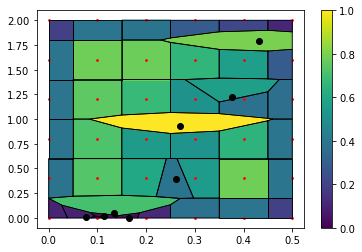

In [5]:
#low boundary window
win_l = (0,.5,0,2) #xmin, xmax, ymin, ymax
boundary_l = make_boundary(win_l)

mesh = 6
dummy_1 = np.linspace(win_l[0],win_l[1],num = mesh)
dummy_2 = np.linspace(win_l[2],win_l[3],num= int(mesh))
X1,Y1 = np.meshgrid(dummy_1,dummy_2)
X = X1.reshape(-1)
Y = Y1.reshape(-1)
dummy = np.stack((X,Y),axis=1)
dummyP_low =  np.vstack([dummy,pd1_low]) #The combination of data and dummy points

_,areas_l = get_areas(dummyP_low,boundary_l) #compute the areas variable for the set P

V = Voronoi(dummyP_low) #computes the unboundary Voronoi cells
diameter = np.linalg.norm(boundary_l.ptp(axis=0)) #Compute the diameter, which allows an initial restriction of the infinite polygons
polys = voronoi_polygons(V,diameter) #Get initial polygons
boundary_polygon = Polygon(boundary_l) #Create a polygon of the boundary (will be a rectangle)
#The loop will create new polygons whereby the infinite polygons are intersected with the boundary polygon, therefore creating 
#the tessellation of the window inside the boundary
n=0
for p in polys:
    x, y = zip(*p.intersection(boundary_polygon).exterior.coords) #get the polygon that is the intersection of the voronoi cell and the boundary
    plt.plot(x, y, 'k-',linewidth=0.85) #plot the resulting voronoi cell
    #plt.fill_between(x, y, color='red', alpha=spatial_pattern[n])
    d_prop = dummyP_low[n,:]
    plt.fill(x, y, color= cm.viridis(A(d_prop.reshape(-1,2),dummyP_low,areas_l)))
    #plt.fill_between(x, y, color='blue', alpha=A(d_prop.reshape(-1,2),pd1_low,areas_l))
    n=n+1
    
plt.scatter(*dummyP_low.T,color='red',s=3) #plot the diagram points
plt.scatter(*pd1_low.T,color='black')
plt.colorbar()
#plt.scatter(*dummyP_low.T,color='blue')



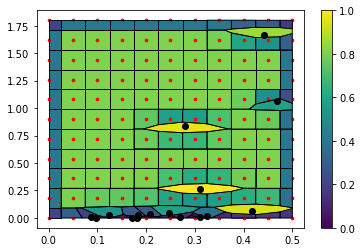

In [6]:
#medium boundary window
win_m = (0,.5,0,1.8) #xmin, xmax, ymin, ymax
boundary_m = make_boundary(win_m)

mesh = 11
dummy_1 = np.linspace(win_m[0],win_m[1],num = mesh)
dummy_2 = np.linspace(win_m[2],win_m[3],num= int(mesh))
X1,Y1 = np.meshgrid(dummy_1,dummy_2)
X = X1.reshape(-1)
Y = Y1.reshape(-1)
dummy = np.stack((X,Y),axis=1)
dummyP_med =  np.vstack([dummy,pd1_med]) #The combination of data and dummy points
_,areas_m = get_areas(dummyP_med,boundary_m) #compute the areas variable for the set P

V = Voronoi(dummyP_med) #computes the unboundary Voronoi cells
diameter = np.linalg.norm(boundary_m.ptp(axis=0)) #Compute the diameter, which allows an initial restriction of the infinite polygons
polys = voronoi_polygons(V,diameter) #Get initial polygons
boundary_polygon = Polygon(boundary_m) #Create a polygon of the boundary (will be a rectangle)
#The loop will create new polygons whereby the infinite polygons are intersected with the boundary polygon, therefore creating 
#the tessellation of the window inside the boundary
n=0
for p in polys:
    x, y = zip(*p.intersection(boundary_polygon).exterior.coords) #get the polygon that is the intersection of the voronoi cell and the boundary
    plt.plot(x, y, 'k-',linewidth=0.85) #plot the resulting voronoi cell
    #plt.fill_between(x, y, color='red', alpha=spatial_pattern[n])
    d_prop = dummyP_med[n,:]
    plt.fill(x, y, color= cm.viridis(A(d_prop.reshape(-1,2),dummyP_med,areas_m)))
    #plt.fill_between(x, y, color='blue', alpha=A(d_prop.reshape(-1,2),pd1_low,areas_l))
    n=n+1
plt.scatter(*dummyP_med.T,color='red',s=7)
plt.scatter(*pd1_med.T,color='black') #plot the diagram points
plt.colorbar()


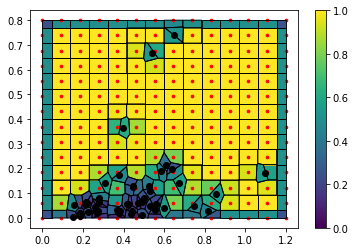

In [7]:
#high boundary window
win_h = (0,1.2,0,.8) #xmin, xmax, ymin, ymax
boundary_h = make_boundary(win_h)

mesh = 14
dummy_1 = np.linspace(win_h[0],win_h[1],num = mesh)
dummy_2 = np.linspace(win_h[2],win_h[3],num= int(mesh))
X1,Y1 = np.meshgrid(dummy_1,dummy_2)
X = X1.reshape(-1)
Y = Y1.reshape(-1)
dummy = np.stack((X,Y),axis=1)
dummyP_hig =  np.vstack([dummy,pd1_hig]) #The combination of data and dummy points
_,areas_h = get_areas(dummyP_hig,boundary_h) #compute the areas variable for the set P

V = Voronoi(dummyP_hig) #computes the unboundary Voronoi cells
diameter = np.linalg.norm(boundary_h.ptp(axis=0)) #Compute the diameter, which allows an initial restriction of the infinite polygons
polys = voronoi_polygons(V,diameter) #Get initial polygons
boundary_polygon = Polygon(boundary_h) #Create a polygon of the boundary (will be a rectangle)
#The loop will create new polygons whereby the infinite polygons are intersected with the boundary polygon, therefore creating 
#the tessellation of the window inside the boundary
n=0
for p in polys:
    x, y = zip(*p.intersection(boundary_polygon).exterior.coords) #get the polygon that is the intersection of the voronoi cell and the boundary
    plt.plot(x, y, 'k-',linewidth=0.85) #plot the resulting voronoi cell
    #plt.fill_between(x, y, color='red', alpha=spatial_pattern[n])
    d_prop = dummyP_hig[n,:]
    plt.fill(x, y, color= cm.viridis(A(d_prop.reshape(-1,2),dummyP_hig,areas_h)))
    #plt.fill_between(x, y, color='blue', alpha=A(d_prop.reshape(-1,2),pd1_low,areas_l))
    n=n+1
plt.scatter(*dummyP_hig.T,color='red',s=7)
plt.scatter(*pd1_hig.T,color='black') #plot the diagram points
plt.colorbar()

In [8]:
def Hu(u,data,kappa):
    """    
    Reference the text below Eq. (31) in Baddeley paper. 
    
    @param u: a 1x2 array, the point with which to compare with data
    @param data: The observed diagram (an nx2 array)
    @param kappa: The distance jump vector (a kx1 array)
    @output out: an integer value
    """
    v=0 #initialize
    for i in range(0,data.shape[0]):
        dist = np.sqrt(np.sum(np.square(u-data[i,:]))) 
        if dist > 0:
            v += dist**(-2/kappa)
    out = -v
    return out

def get_theta_loglin(P,data,boundary,r,prnt = True):
    #i-
    """
    Estimates the interaction parameter theta via log-linear Poisson regression
    SOFT CORE VARIATION
    @param P: the Voronoi cell generating P (an mx2 array)
    @param data: The observed diagram (an nx2 array)
    @param boundary: 4x2 list of rectangle vertices in cylcic order (best to just use the make_boundary function to create boundary from a 1-d vector)
    @param r: The distance jump vector (a kx1 array)
    @param prnt: if True prints a summary of the loglinear regression results
    @output theta_loglin: the estimated interaction parameter
    """
    spatial_pattern = np.array(list(get_areas(P,boundary)[1].values())) 
    unnorm_areas = np.array(list(get_unnormalized_areas(P,boundary)[1].values())) 
    #Compute the interaction indicator vectors
    H = np.zeros([P.shape[0],2]) #initialize H
    for j in range(P.shape[0]):
        H[j] = Hu(P[j,:],data,r)
    
    y = np.zeros(P.shape[0]) #initialize the response variable
    for j in range(P.shape[0]):
        p = P[j,:] #j-th point of the Voronoi generating set
        for i in range(data.shape[0]): #loop over true diagram P
            d = data[i,:] #get ith diagram point
            if np.sum(p - d) == 0: 
                y[j] = 1/spatial_pattern[j]  #if pj is a true diagram point, assign the inverse of its area
                break
            else:
                y[j] = 0 #otherwise assign it to 0
    
    #Perform loglinear regression
    #create dataframe of response and variables
    
    columns = ["response"]
    columns.append("V1")
    #columns.append("Pnogamma")
    #columns.append("log(spatialpattern)")
    columns.append("weights")
    df = pd.DataFrame(np.vstack([y,H[:,:1].T,spatial_pattern]).T,columns = columns)
    #df = pd.DataFrame(np.vstack([y,H[:,:1].T,np.log(spatial_pattern),spatial_pattern]).T,columns = columns)

    
    df.head()

    fam = Poisson()
    f = 'response ~ V1 - 1'
    yres, X = patsy.dmatrices(f, df, return_type='matrix')
    p_model = sm.GLM(yres, X, family=fam, var_weights = unnorm_areas)
    
    
    result = p_model.fit()
    if prnt:
        print(result.summary())
    theta_loglin = result.params
    return theta_loglin

In [9]:
kappa = .2

In [10]:
theta_low = get_theta_loglin(dummyP_low, pd1_low, boundary_l, kappa)
print(theta_low**(kappa/2))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                   44
Model:                            GLM   Df Residuals:                       43
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1.3954
Date:                Mon, 10 Apr 2023   Deviance:                       2.3496
Time:                        11:53:45   Pearson chi2:                     4.44
No. Iterations:                     6   Pseudo R-squ. (CS):           -0.01024
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V1          3.632e-17   2.86e-15      0.013      0.9

In [11]:
kappa_m=.5
theta_med = get_theta_loglin(dummyP_med, pd1_med, boundary_m, kappa_m)
print(theta_med**(kappa/2))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                  137
Model:                            GLM   Df Residuals:                      136
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1.0887
Date:                Mon, 10 Apr 2023   Deviance:                       1.9931
Time:                        11:53:45   Pearson chi2:                     3.45
No. Iterations:                     5   Pseudo R-squ. (CS):          -0.006326
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V1          2.389e-11   2.07e-09      0.012      0.9

In [12]:
kappa_h=.2
theta_hig = get_theta_loglin(dummyP_hig, pd1_hig, boundary_h, kappa)
print(theta_hig**(kappa/2))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                  242
Model:                            GLM   Df Residuals:                      241
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1.1670
Date:                Mon, 10 Apr 2023   Deviance:                       2.0998
Time:                        11:53:46   Pearson chi2:                     1.66
No. Iterations:                     4   Pseudo R-squ. (CS):          -0.002955
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V1          3.108e-24   7.27e-23      0.043      0.9

## Means of Guassian mixture for move step

In [13]:
#plt.scatter(*pd1_low.T)
#mg_low2 = np.array([[.43,1.77],[.38,1.24],[.27,.96],[.26,.45],[.12,0]])
#plt.scatter(*mg_low2.T)

N = 4   #Takes N most persistent points in PD
pd_sort = pd1_low[pd1_low[:, 1].argsort()[::-1]]
ft = pd_sort[:N,:]
ns=np.average(pd_sort[N+1:,:],axis=0)
#ns = [.25,0] #manual noise location
mg_low= np.vstack((ft,ns))
#plt.scatter(*mg_low.T)

In [14]:
#plt.scatter(*pd1_med.T)
N = 4   #Takes N most persistent points in PD
pd_sort = pd1_med[pd1_med[:, 1].argsort()[::-1]]
ft = pd_sort[:N,:]
ns=np.average(pd_sort[N+1:,:],axis=0)
#ns = [.25,0] #manual noise location
mg_med= np.vstack((ft,ns))
#plt.scatter(*mg_med.T)

In [15]:
#plt.scatter(*pd1_hig.T)
#mg_hig = np.array([[.65,.75],[.54,.66],[.4,.36],[.3,0],[.7,0]])
N = 4   #Takes N most persistent points in PD
pd_sort = pd1_hig[pd1_hig[:, 1].argsort()[::-1]]
ft = pd_sort[:N,:]
ns=np.average(pd_sort[N+1:,:],axis=0)
#ns = [.25,0] #manual noise location
mg_hig= np.vstack((ft,ns))
#plt.scatter(*mg_hig.T)

In [45]:
np.random.seed(323)
steps = 100000
burnin =0
p_a = 0.33
p_r = 0.33
p_m = 0.34


lambdaW = pd1_low.shape[0]
mg = mg_low #the means of the components
sg = np.array([0.005,0.005,.005,.005,.03]) #the st. devs of the components
wt = np.array([0.1,0.1,.1,.1,.6]) #the weights of the components

#def RPDG_multi(steps,burnin,D_current, P, kappa, sigma,boundary,lambdaW,mg,sg,wt,probs=[1/3,1/3,1/3],areas = None):

D_low = RPDG_multi(steps, burnin, pd1_low, dummyP_low, kappa, theta_low**(kappa/2), boundary_l, lambdaW, mg, sg, wt, probs=[p_a,p_r,p_m])

C:\Users\iiic1\AppData\Local\Temp\ipykernel_7636\3964954237.py:162: RuntimeWarning: divide by zero encountered in log
  H += np.log(h(x1,x2,kappa,sigma)) #compute the interaction then take the log
C:\Users\iiic1\AppData\Local\Temp\ipykernel_7636\3874072943.py:134: RuntimeWarning: divide by zero encountered in log
  Hrat = np.exp(np.log(H_prop)-np.log(H_old))
C:\Users\iiic1\AppData\Local\Temp\ipykernel_7636\3874072943.py:27: RuntimeWarning: divide by zero encountered in log
  h_prop = h_prop + np.log(h(D_current[i,:],d_prop,kappa,sigma))


In [46]:
np.random.seed(5454)
steps = 100000
burnin =0
p_a = 0.33
p_r = 0.33
p_m = 0.34


lambdaW = pd1_med.shape[0]
mg = mg_med #the means of the components
sg = np.array([0.005,0.005,.005,.005,.03]) #the st. devs of the components
wt = np.array([0.1,0.1,.1,.1,.6]) #the weights of the components


D_med = RPDG_multi(steps, burnin, pd1_med, dummyP_med, kappa_m, theta_med**(kappa/2), boundary_m, lambdaW, mg, sg, wt, probs=[p_a,p_r,p_m])

C:\Users\iiic1\AppData\Local\Temp\ipykernel_7636\3874072943.py:55: RuntimeWarning: divide by zero encountered in log
  h_prop = h_prop + np.log(h(D_prop[i,:],d_prop.reshape(-1,2),kappa,sigma))
C:\Users\iiic1\AppData\Local\Temp\ipykernel_7636\3874072943.py:56: RuntimeWarning: divide by zero encountered in true_divide
  a = (D_current.shape[0]-1)/(np.exp(h_prop)*A(d_prop.reshape(-1,2),P,areas)*lambdaW) #compute the acceptance probability
C:\Users\iiic1\AppData\Local\Temp\ipykernel_7636\3964954237.py:162: RuntimeWarning: divide by zero encountered in log
  H += np.log(h(x1,x2,kappa,sigma)) #compute the interaction then take the log
C:\Users\iiic1\AppData\Local\Temp\ipykernel_7636\3874072943.py:134: RuntimeWarning: divide by zero encountered in log
  Hrat = np.exp(np.log(H_prop)-np.log(H_old))
C:\Users\iiic1\AppData\Local\Temp\ipykernel_7636\3874072943.py:134: RuntimeWarning: invalid value encountered in subtract
  Hrat = np.exp(np.log(H_prop)-np.log(H_old))
C:\Users\iiic1\AppData\Local\Te

In [56]:
np.random.seed(76767)
steps = 100000
burnin =0
p_a = 0.33
p_r = 0.33
p_m = 0.34


lambdaW = pd1_hig.shape[0]
mg = mg_hig #the means of the components
sg = np.array([0.005,0.005,.005,.03,.03]) #the st. devs of the components
wt = np.array([0.11,0.11,.11,.07,.6]) #the weights of the components


D_hig = RPDG_multi(steps, burnin, pd1_hig, dummyP_hig, kappa_h, theta_hig**(kappa/2), boundary_h, lambdaW, mg, sg, wt, probs=[p_a,p_r,p_m])

C:\Users\iiic1\AppData\Local\Temp\ipykernel_7636\3964954237.py:162: RuntimeWarning: divide by zero encountered in log
  H += np.log(h(x1,x2,kappa,sigma)) #compute the interaction then take the log
C:\Users\iiic1\AppData\Local\Temp\ipykernel_7636\3874072943.py:134: RuntimeWarning: divide by zero encountered in log
  Hrat = np.exp(np.log(H_prop)-np.log(H_old))
C:\Users\iiic1\AppData\Local\Temp\ipykernel_7636\3874072943.py:27: RuntimeWarning: divide by zero encountered in log
  h_prop = h_prop + np.log(h(D_current[i,:],d_prop,kappa,sigma))


In [58]:
np.save('PDchains/LowNoiseSC', D_low)
np.save('PDchains/MedNoiseSC', D_med)
np.save('PDchains/HigNoiseSC', D_hig)